### Import the library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, r2_score,mean_absolute_percentage_error,mean_absolute_error
from tqdm import tqdm
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from prettytable import PrettyTable

### Load data

In [2]:
df = pd.read_csv("../data/laptop_final.csv")

In [3]:
# Drop unecessary columns
# Drop Ethernet LAN due to its large missing values 
df2=df.drop(columns=["link","name","Total Score","Display Score","Portability Score","Work Score","Cost","CPU: Codename","GPU: Name","CPU: Name","Ethernet LAN"])
df2 = df2.drop_duplicates()

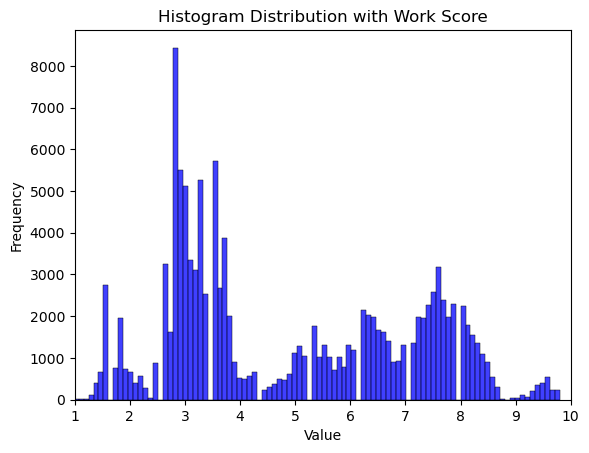

In [4]:
# play score distribution 
sns.histplot(df2['Play Score'], bins=100, color='blue')

plt.title("Histogram Distribution with Work Score")
plt.xlabel("Value")
plt.xlim(1,10)
plt.ylabel("Frequency")

plt.show()

#### Drop nan values

In [5]:
df2.isna().sum()

Display Size                                   0
Resolution: width                              0
Resolution: height                             0
Refresh Rate                                   0
Panel Type                                     0
Disk Capacity                                  0
SSD                                            0
HDD                                            0
SSHD                                           0
Optane                                         0
RAM Capacity                                 261
RAM Type                                   27160
OS                                           665
Body material: plastic / polycarbonate         0
Body material: aluminum                        0
Body material: magnesium alloy                 0
Body material: glass fiber                     0
Body material: carbon                          0
Body material: magnesium-lithium alloy         0
Body material: plastic                         0
Body material: matte

In [6]:
df3 = df2.dropna() # drop all nan value due to the large datset 
print("The number of data points before drop nan is:{} and after drop nan values is:{}".format(df.shape[0], df2.shape[0]))

The number of data points before drop nan is:289171 and after drop nan values is:157898


### Add more features following our knowledge about laptop architecture


+ **CPU Processing Power** (Ghz)= CPU: Core x CPU: Base Frequency
   
      - CPU: Core is the number of core in CPU 
      - CPU: Base Frequency is the speed where each core operates (GHz)
  
  ⇒ This feature tells the total number of cycles the CPU can operate in a second (Ghz)

+ **GPU Band Width** (bits/s) = GPU: Memory Frequency × GPU: Memory Bus 
  
      - GPU: Memory Frequency is the clock speed of GPU memory (Mhz)
      - GPU: Memory Bus is the number of bits the memory can transfer per clock cycle (bits/cycle)
  
  ⇒ Represent how fast data can move between the GPU memory and the GPU’s cores for processing (bits/s)

+ **GPU Efficiency** (cycles/J) = GPU: Base Clock / GPU: Power Consumption

      -GPU: Base Clock is the clock speed of GPU core (Ghz)
      -GPU: Power Consumption is the power GPU uses during operation (W)

  ⇒ Represent how much work GPU can do per unit of energy consumption (cycles/J)

In [7]:
df3["CPU: Processing Power"]=df3["CPU: Core"]*df3["CPU: Base frequency"]
df3["GPU: Band Width"]=df3["GPU: Memory Frequency (MHz)"]*df3["GPU: Memory Bus"]
df3["GPU: Efficiency"]=df3["GPU: Base Clock"]/df3["GPU: Power Consumption"]
added_features=["CPU: Processing Power","GPU: Band Width","GPU: Efficiency"]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3900\2940952750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["CPU: Processing Power"]=df3["CPU: Core"]*df3["CPU: Base frequency"]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3900\2940952750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["GPU: Band Width"]=df3["GPU: Memory Frequency (MHz)"]*df3["GPU: Memory Bus"]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3900\2940952750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

#### Train Test split 

In [7]:
target="Play Score"
X=df3.drop(columns=[target])
y=df3[target]

In [8]:
# train validation split with ratio is 0.2 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)
# features for encoding 
cols_to_encode=["Panel Type","RAM Type","OS","GPU: Architecture","GPU: Memory Type"]

#### Encode categorical columns using target encoding

In [10]:
for col in cols_to_encode:
    print(f"Number of unique values in {col}: ",df3[col].nunique())

Number of unique values in Panel Type:  11
Number of unique values in RAM Type:  5
Number of unique values in OS:  9
Number of unique values in GPU: Architecture:  40
Number of unique values in GPU: Memory Type:  3


In [11]:
# Encode the categorical features 
encoder=TargetEncoder(cols=cols_to_encode)
X_train=encoder.fit_transform(X_train,y_train)
X_test=encoder.transform(X_test)

### Features Selection

In [12]:
# identify the numerical and the categorical features for features selection
numerical_features=["Display Size","Refresh Rate","Resolution: width","Resolution: height","Disk Capacity","RAM Capacity","Dimension: Depth","Weight",
                    "Num of M.2 Slot","USB Type-C","USB Type-A","HDMI","Bluetooth",
                    "CPU: Max operating temperature","CPU: Core","CPU: Thread","CPU: Base frequency",
                    "CPU: Max frequency","CPU: Release quarter","CPU: LL Cache","CPU: Lithography",
                    "GPU: Process Size (nm)","GPU: Memory Frequency (MHz)","GPU: Memory Size",
                    "GPU: Base Clock","GPU: Memory Bus","GPU: Release quarter","GPU: Power Consumption"]+added_features          
categorical_features=list(set(df3.columns.tolist())-set(numerical_features+[target]))
print(categorical_features)
print(len(categorical_features))

['Body material: aluminum', 'GPU: Architecture', 'Body material: magnesium-lithium alloy', 'Body material: black synthetic material', 'Body material: matte', 'Card Reader', 'Body material: glass fiber', 'GPU: Memory Type', 'SSHD', 'Panel Type', 'SSD', 'Body material: carbon', 'Backlit keyboard', 'Fingerprint reader', 'Security Lock slot', 'OS', 'HDD', 'Body material: plastic / polycarbonate', 'Body material: magnesium alloy', 'Optane', 'Body material: plastic', 'RAM Type']
22


* Normalize for features selection

In [13]:
normalized_X_train = X_train.copy()
normalized_X_train[numerical_features]=(X_train[numerical_features] - X_train[numerical_features].mean())/X_train[numerical_features].std()
normalized_X_train.head(5)

,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,SSHD,Optane,...,GPU: Memory Type,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption,CPU: Processing Power,GPU: Band Width,GPU: Efficiency
137693,-0.114772,-0.291078,-0.351188,-0.676833,4.888397,-0.373210,1.0,0.0,0.0,0.0,...,3.004071,-0.528673,-0.880823,-0.979750,-0.953150,-0.336549,-0.911812,-0.619228,-0.475099,0.199140
242946,-0.114772,-0.291078,-0.351188,0.580422,8.066933,0.817404,1.0,0.0,0.0,0.0,...,6.860246,-0.096172,1.221681,2.391924,0.435155,2.320514,1.716330,1.462184,-0.183558,-0.323388
212938,1.447543,-1.010824,-0.980932,-0.676833,2.605149,0.817404,1.0,0.0,0.0,0.0,...,3.004071,-0.528673,-0.880823,-0.979750,-0.953150,-0.336549,-0.911812,-0.659644,-0.475099,0.199140
132950,-0.114772,-0.291078,-0.351188,0.221206,7.067197,-0.271611,1.0,1.0,0.0,0.0,...,6.860246,-0.204297,0.170429,1.306131,0.435155,0.194864,0.665073,-0.740475,-0.256443,-0.134896
204563,-0.114772,-1.537139,-1.442744,-0.676833,2.605149,-0.662133,1.0,0.0,0.0,0.0,...,3.004071,-0.528673,-0.880823,-0.979750,-0.953150,-0.336549,-0.911812,-0.659644,-0.475099,0.199140


* Using mutual info and anova to find the most relevant categorical features

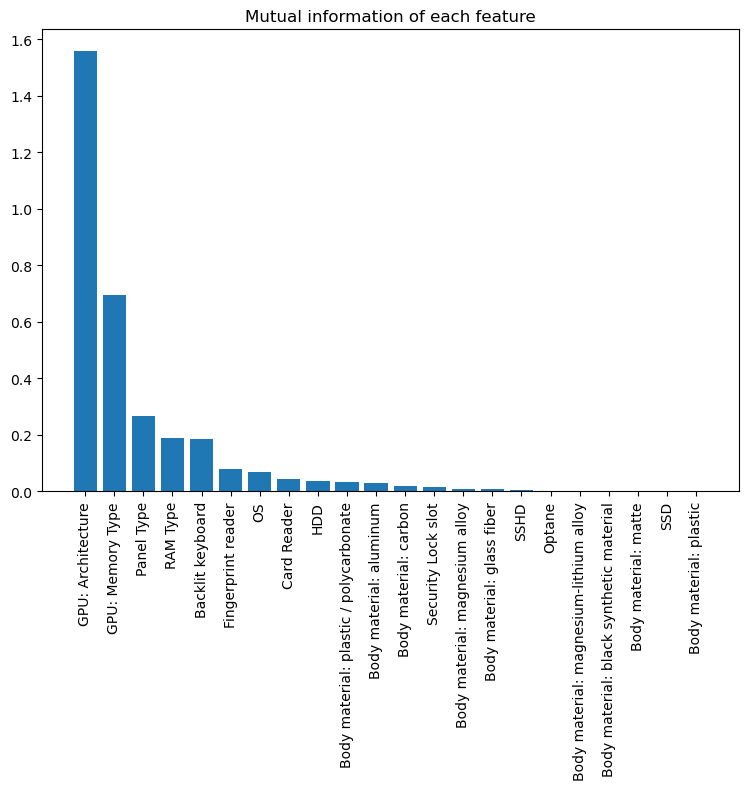

In [14]:
# mutual info
fs = SelectKBest(score_func=mutual_info_regression, k=10)
fs.fit(normalized_X_train[categorical_features],y_train)
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
d={a:b for a,b in d}
plt.figure(figsize=(9,6))
plt.bar(d.keys(),d.values())
plt.xticks(rotation=90)
plt.title("Mutual information of each feature")
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 3  4 20] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


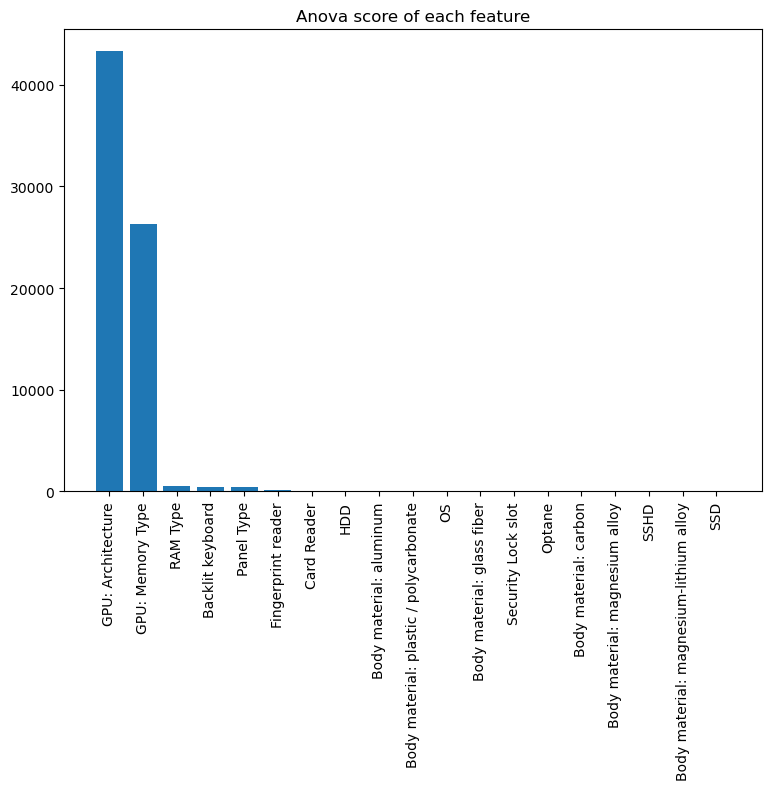

In [15]:
#anova
fs2 = SelectKBest(score_func=f_classif, k=10)
fs2.fit(normalized_X_train[categorical_features],y_train)
fs2.get_feature_names_out()
e=sorted([(a,b) for a,b in zip(categorical_features,fs2.scores_) if not np.isnan(b)],key=lambda x:x[1],reverse=True)
e={a:b for a,b in e}
plt.figure(figsize=(9,6))
plt.bar(e.keys(),e.values())
plt.xticks(rotation=90) 
plt.title("Anova score of each feature")
plt.show()

* Using pearson correlation, spearman to find the most relevant in numerical features

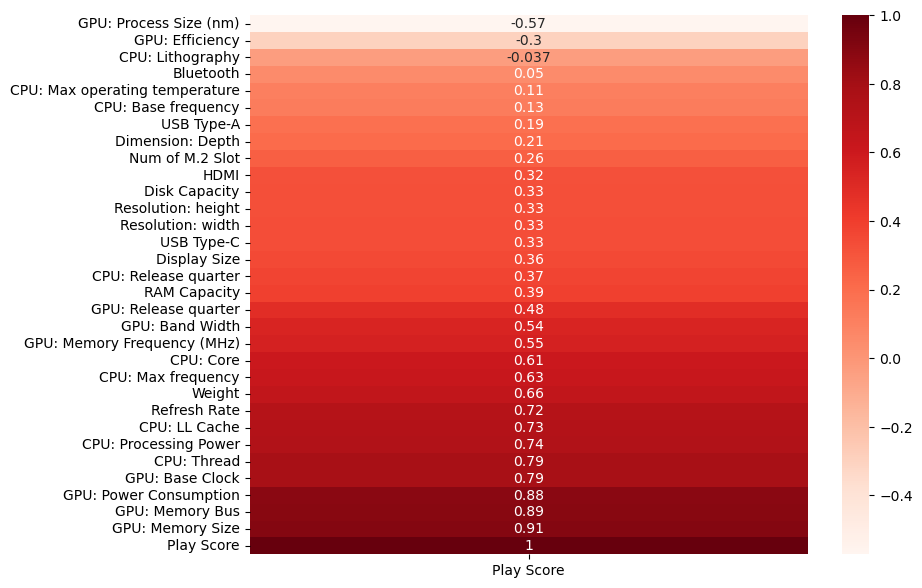

In [16]:
# using pearsonscore
train_set=normalized_X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr()[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

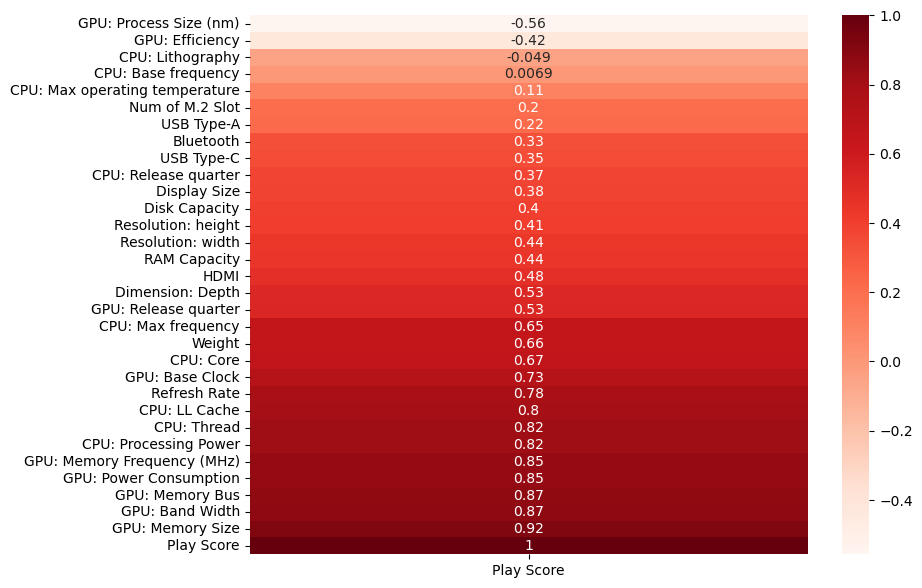

In [17]:
# using spearman score
train_set=normalized_X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr(method = 'spearman')[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

* Using Permutation Importance method to choose important features in 2 groups

In [18]:
# Choose candidate features in 2 groups
candidate_num_features = [f for f in target_correlation.index if abs(target_correlation[target].loc[f])>=0.5 and f!=target]
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
candidate_cat_features = list(feat[0] for feat in d[:5])
candidate_featues = candidate_cat_features + candidate_num_features
print(candidate_featues)

['GPU: Architecture', 'GPU: Memory Type', 'Panel Type', 'RAM Type', 'Backlit keyboard', 'Refresh Rate', 'Dimension: Depth', 'Weight', 'CPU: Core', 'CPU: Thread', 'CPU: Max frequency', 'CPU: LL Cache', 'GPU: Process Size (nm)', 'GPU: Memory Frequency (MHz)', 'GPU: Memory Size', 'GPU: Base Clock', 'GPU: Memory Bus', 'GPU: Release quarter', 'GPU: Power Consumption', 'CPU: Processing Power', 'GPU: Band Width']


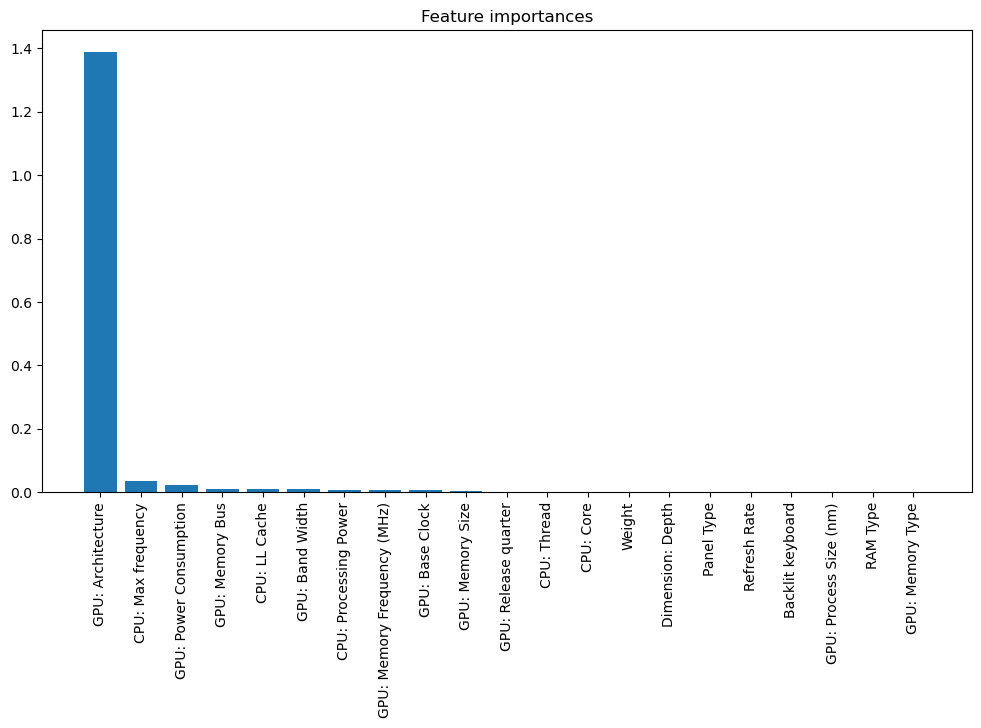

In [28]:
candidate_X = normalized_X_train[candidate_featues]
model_to_select_feature = RandomForestRegressor(n_estimators=5,min_samples_leaf=2)
model_to_select_feature.fit(candidate_X, y_train)
imp_dict = permutation_importance(model_to_select_feature,candidate_X,y_train,n_repeats=10,random_state=42,scoring="r2",n_jobs=-1)
imp_score=imp_dict.importances_mean
indices = np.argsort(imp_score)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature importances')
plt.bar(range(len(indices)), imp_score[indices])
plt.xticks(range(len(indices)), candidate_X.columns[indices], rotation='vertical')
plt.show()

In [29]:
#Choose importatn features based on the importance score in RF
final_features = [c for c in candidate_X.columns[indices[:10]]]
final_features

['GPU: Architecture',
 'CPU: Max frequency',
 'GPU: Power Consumption',
 'GPU: Memory Bus',
 'CPU: LL Cache',
 'GPU: Band Width',
 'CPU: Processing Power',
 'GPU: Memory Frequency (MHz)',
 'GPU: Base Clock',
 'GPU: Memory Size']

In [30]:
better_X_train=X_train[final_features]
better_X_test=X_test[final_features]

In [31]:
chosen_cat_features = ['GPU: Architecture']
chosen_num_features=list(set(final_features)-set(chosen_cat_features))

#### Visualize  

* Boxplot

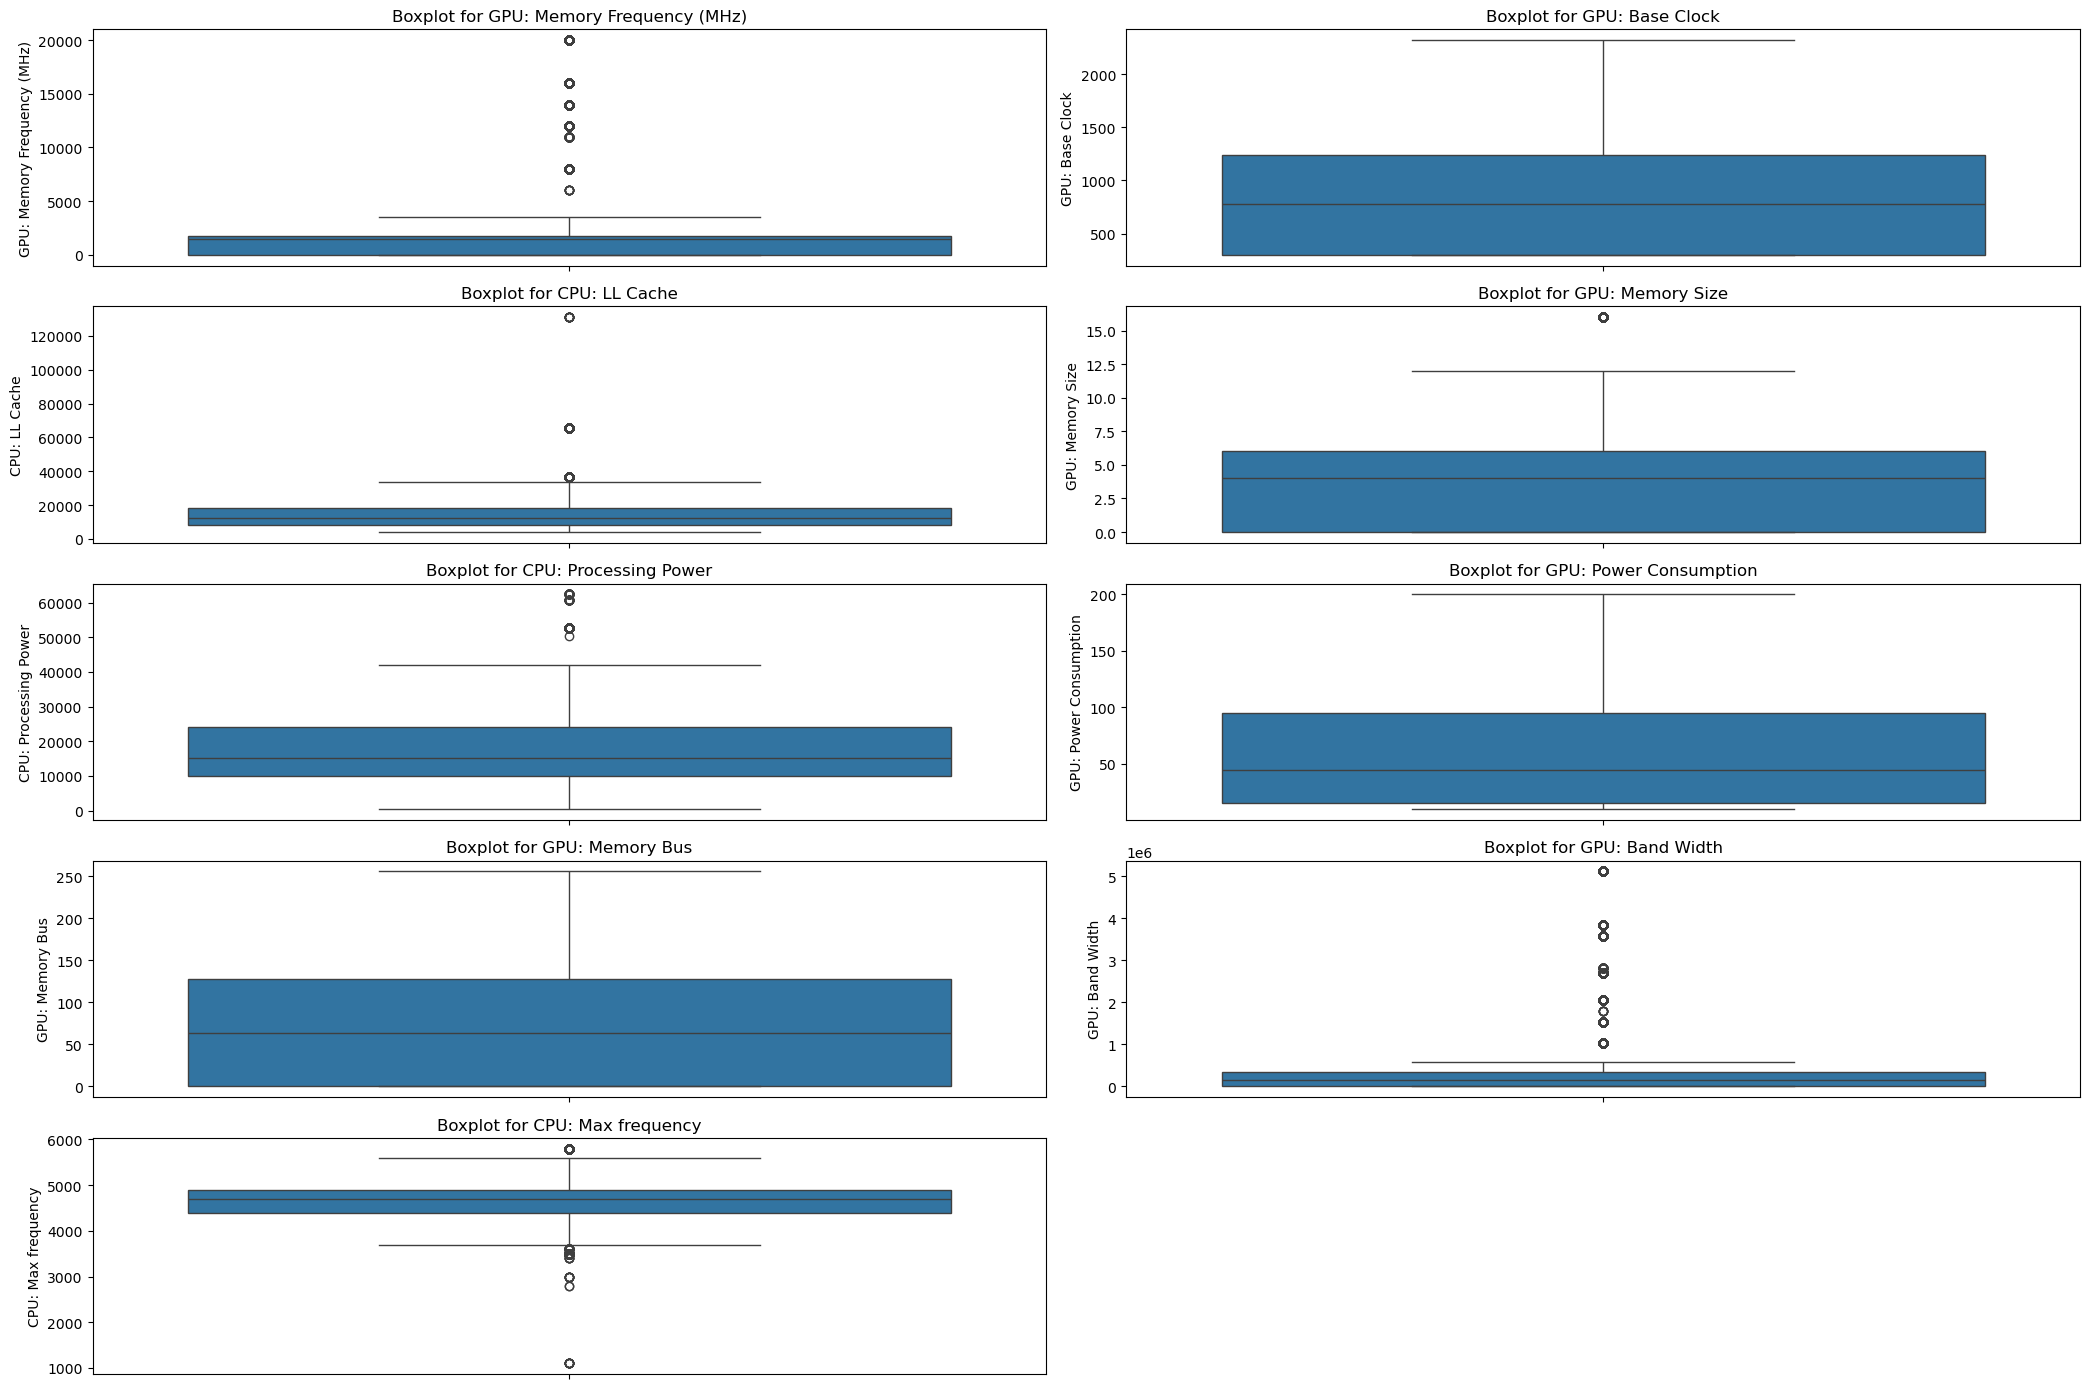

In [32]:
plt.figure(figsize=(21, 14))
for i, var in enumerate(chosen_num_features):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(y=X_train[var])  # Explicitly pass the column to x
    plt.title(f'Boxplot for {var}')
plt.tight_layout()
plt.show()

Distribution of each feature

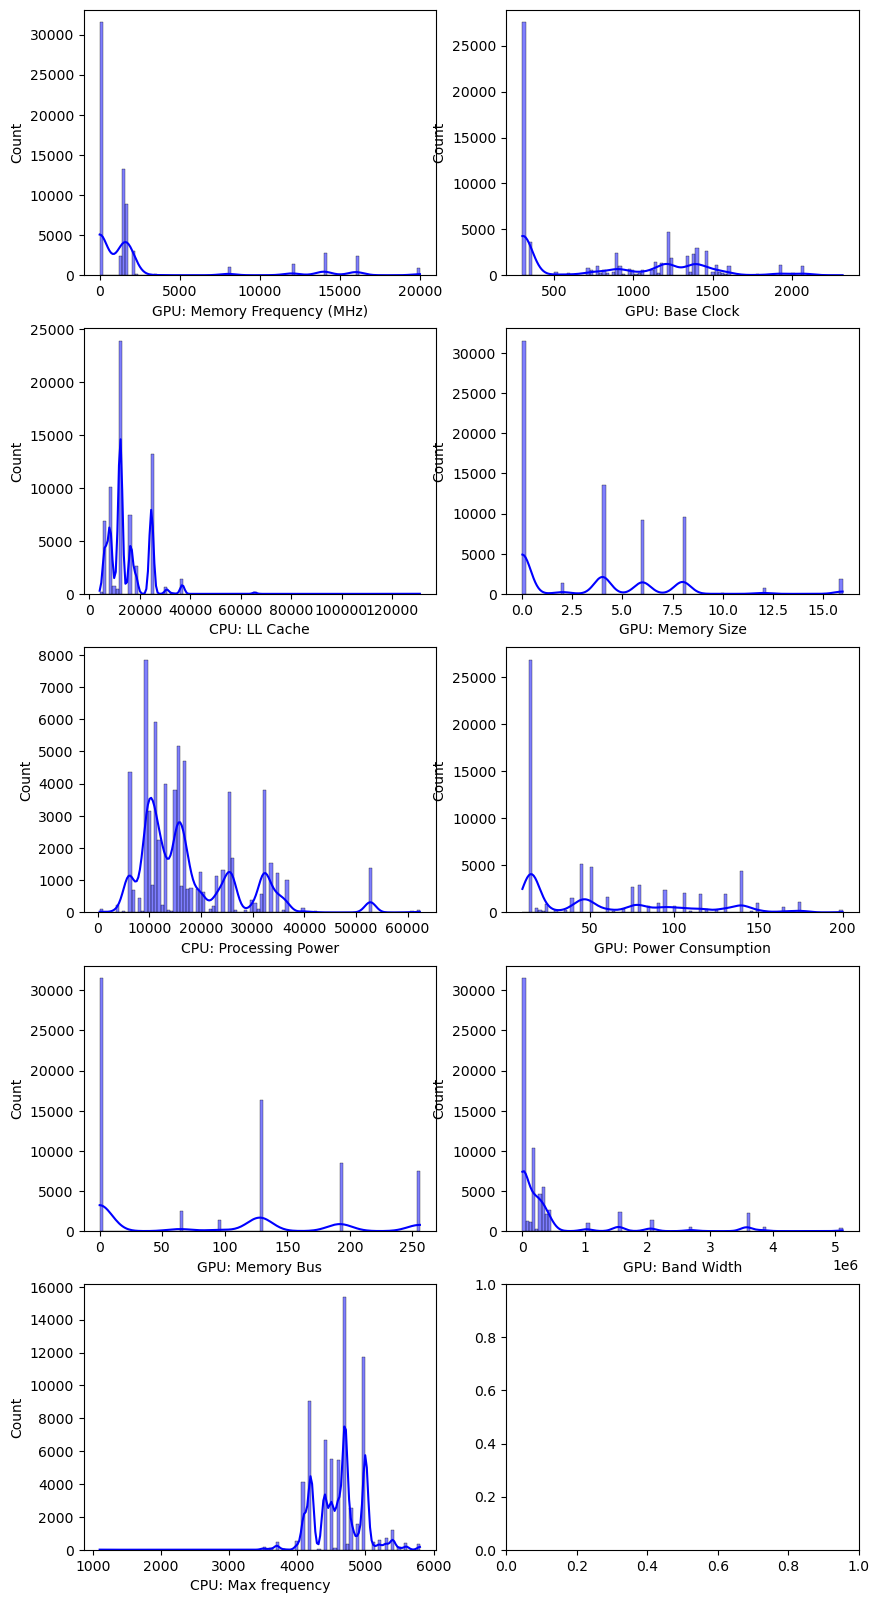

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
axes = axes.flatten() 
for i, column in enumerate(chosen_num_features):
    ax = axes[i]
    sns.histplot(better_X_train[column], kde=True, bins=100, color='blue', ax= ax)

Detect outliers

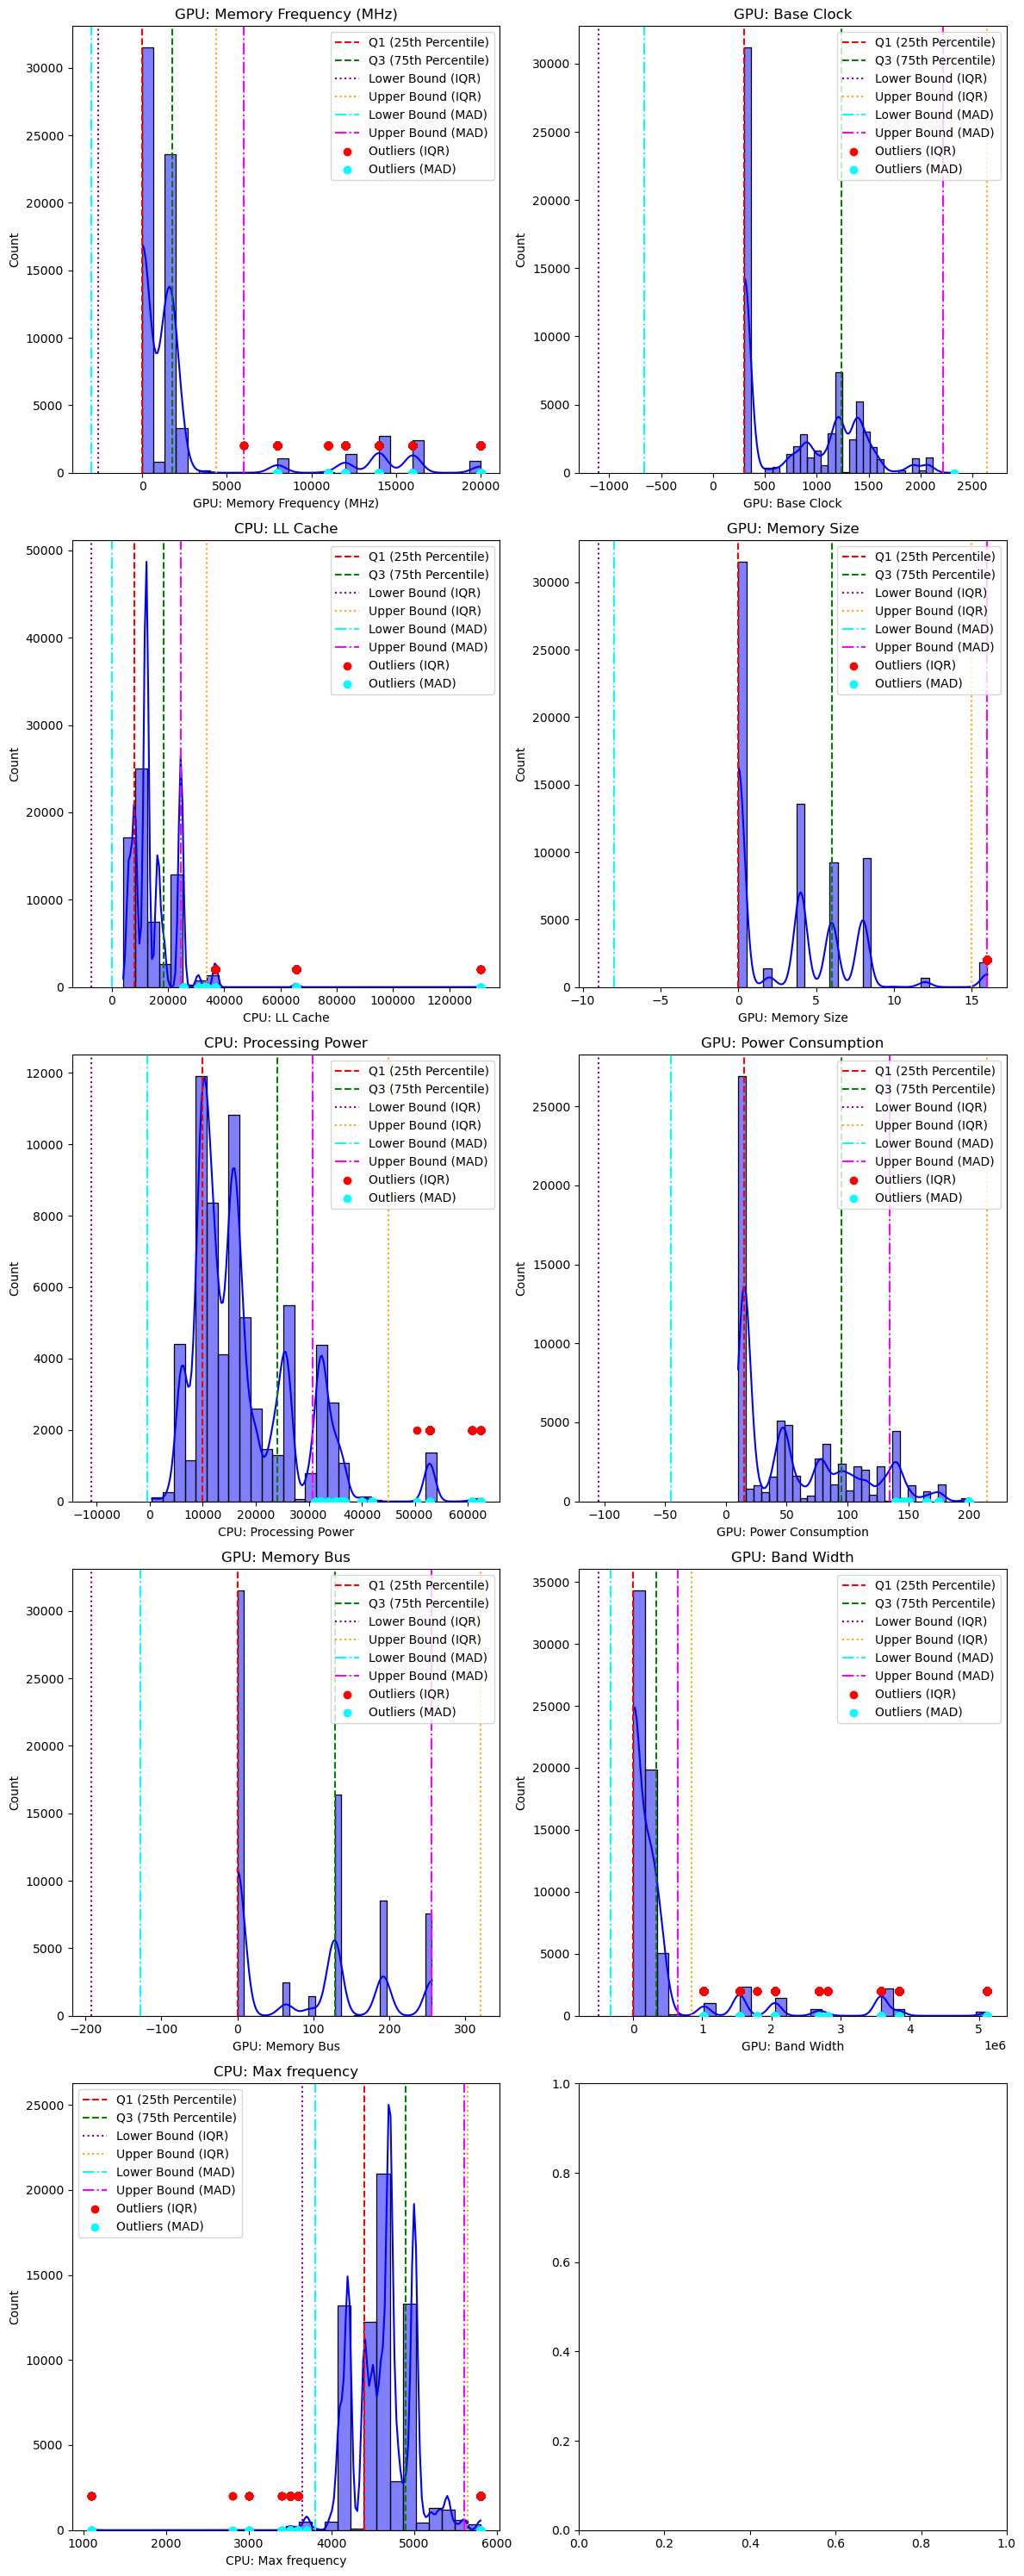

In [34]:
# visual outlier of data based on IQR and MAD
def detect_outliers(data):
    # IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - 1.5 * IQR
    upper_bound_iqr = Q3 + 1.5 * IQR
    # MAD
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    lower_bound_mad = median - 3 * mad
    upper_bound_mad = median + 3 * mad
    return Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad
def plot_distribution(data, ax, title):
    Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(data)
    sns.histplot(data, kde=True, bins=30, color='blue', ax=ax)
    ax.axvline(Q1, color="red", linestyle="--", label="Q1 (25th Percentile)")
    ax.axvline(Q3, color="green", linestyle="--", label="Q3 (75th Percentile)")

    ax.axvline(lower_bound_iqr, color="purple", linestyle=":", label="Lower Bound (IQR)")
    ax.axvline(upper_bound_iqr, color="orange", linestyle=":", label="Upper Bound (IQR)")
    ax.axvline(lower_bound_mad, color="cyan", linestyle="-.", label="Lower Bound (MAD)")
    ax.axvline(upper_bound_mad, color="magenta", linestyle="-.", label="Upper Bound (MAD)")

    iqr_outliers = data[(data < lower_bound_iqr) | (data > upper_bound_iqr)]
    mad_outliers = data[(data < lower_bound_mad) | (data > upper_bound_mad)]
    ax.scatter(iqr_outliers, [2000] * len(iqr_outliers), color="red", label="Outliers (IQR)", zorder=5)
    ax.scatter(mad_outliers, [0] * len(mad_outliers), color="cyan", label="Outliers (MAD)", zorder=5)
    ax.set_title(title)
    ax.legend()
n_features = len(chosen_num_features)
n_cols = 2  
n_rows = (n_features + n_cols - 1) // n_cols  
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6 * n_rows))
axes = axes.flatten()  
for i in range(n_features):
    plot_distribution(better_X_train[chosen_num_features[i]], axes[i], chosen_num_features[i])
plt.tight_layout()
plt.show()

### Training

* Normalize

In [71]:
scaler = StandardScaler()
final_X_train=better_X_train.copy()
final_X_test=better_X_test.copy()
final_X_train[chosen_num_features] = scaler.fit_transform(better_X_train[chosen_num_features])
final_X_test[chosen_num_features] = scaler.transform(better_X_test[chosen_num_features])
final_y_train = y_train

In [72]:
print(final_X_train.shape)
print(final_X_test.shape)
print(final_y_train.shape)
print(y_test.shape)


(67891, 10)
(16973, 10)
(67891,)
(16973,)


* Model

In [73]:
models={
    model_name:{} for model_name in ["Ridge Regression","Gradient Boosting",'KNN','Random Forest',"SVM Regression"]
} 

* Grid Search

In [74]:
def best_params_finder(model, param_grid, cv=3, scoring='r2', X_train=final_X_train, y_train=final_y_train, X_test=final_X_test, y_test=y_test):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1,return_train_score=True)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    results_df = pd.DataFrame(grid_search.cv_results_)
    print("\nDetailed Grid Search Results:")
    print(results_df[['params','mean_train_score', 'std_train_score','mean_test_score', 'std_test_score','rank_test_score']])
    print(f"\nBest Parameters: {best_params}")
    print(f"Test Score with Best Estimator: {test_score}")
    return best_params

* K-Nearest Regresion

In [75]:
knn=KNeighborsRegressor()
params_grid_KNN = {
    'n_neighbors': [5,10,15,20],        
    'metric': ['euclidean', 'manhattan', 'minkowski']}

In [76]:
best_params=best_params_finder(knn,params_grid_KNN)
knn.set_params(**best_params)
models["KNN"]["model"]=knn


Detailed Grid Search Results:
                                        params  mean_train_score  \
0    {'metric': 'euclidean', 'n_neighbors': 5}          0.997528   
1   {'metric': 'euclidean', 'n_neighbors': 10}          0.997466   
2   {'metric': 'euclidean', 'n_neighbors': 15}          0.997287   
3   {'metric': 'euclidean', 'n_neighbors': 20}          0.997160   
4    {'metric': 'manhattan', 'n_neighbors': 5}          0.997545   
5   {'metric': 'manhattan', 'n_neighbors': 10}          0.997479   
6   {'metric': 'manhattan', 'n_neighbors': 15}          0.997323   
7   {'metric': 'manhattan', 'n_neighbors': 20}          0.997218   
8    {'metric': 'minkowski', 'n_neighbors': 5}          0.997528   
9   {'metric': 'minkowski', 'n_neighbors': 10}          0.997466   
10  {'metric': 'minkowski', 'n_neighbors': 15}          0.997287   
11  {'metric': 'minkowski', 'n_neighbors': 20}          0.997160   

    std_train_score  mean_test_score  std_test_score  rank_test_score  
0          0

* Ridge Regression

In [77]:
ridge=Ridge()
params_grid_Ridge={"alpha":np.linspace(0,2,100)}

In [78]:
best_params=best_params_finder(ridge,params_grid_Ridge)
ridge.set_params(**best_params)
models["Ridge Regression"]["model"]=ridge


Detailed Grid Search Results:
                             params  mean_train_score  std_train_score  \
0                    {'alpha': 0.0}          0.979748         0.000142   
1   {'alpha': 0.020202020202020204}          0.979748         0.000142   
2    {'alpha': 0.04040404040404041}          0.979748         0.000142   
3    {'alpha': 0.06060606060606061}          0.979748         0.000142   
4    {'alpha': 0.08080808080808081}          0.979748         0.000142   
..                              ...               ...              ...   
95    {'alpha': 1.9191919191919193}          0.979748         0.000142   
96    {'alpha': 1.9393939393939394}          0.979748         0.000142   
97    {'alpha': 1.9595959595959598}          0.979748         0.000142   
98      {'alpha': 1.97979797979798}          0.979748         0.000142   
99                   {'alpha': 2.0}          0.979748         0.000142   

    mean_test_score  std_test_score  rank_test_score  
0          0.979738      

* Random Forest

In [79]:
rf=RandomForestRegressor()
params_grid_RF={"n_estimators":[10,25,50],"min_samples_leaf":[2,5],"min_samples_split":[2,5,10]}

In [80]:
best_params=best_params_finder(rf,params_grid_RF)
rf.set_params(**best_params)
models["Random Forest"]["model"]=rf


Detailed Grid Search Results:
                                               params  mean_train_score  \
0   {'min_samples_leaf': 2, 'min_samples_split': 2...          0.997924   
1   {'min_samples_leaf': 2, 'min_samples_split': 2...          0.997926   
2   {'min_samples_leaf': 2, 'min_samples_split': 2...          0.997926   
3   {'min_samples_leaf': 2, 'min_samples_split': 5...          0.997918   
4   {'min_samples_leaf': 2, 'min_samples_split': 5...          0.997920   
5   {'min_samples_leaf': 2, 'min_samples_split': 5...          0.997926   
6   {'min_samples_leaf': 2, 'min_samples_split': 1...          0.997906   
7   {'min_samples_leaf': 2, 'min_samples_split': 1...          0.997908   
8   {'min_samples_leaf': 2, 'min_samples_split': 1...          0.997910   
9   {'min_samples_leaf': 5, 'min_samples_split': 2...          0.997788   
10  {'min_samples_leaf': 5, 'min_samples_split': 2...          0.997801   
11  {'min_samples_leaf': 5, 'min_samples_split': 2...          0.9977

* Support Vector Machine

In [81]:
params_grid_SVM = {
    'C': [0.1,0.5,1]             
}
svr=SVR()

In [82]:
best_params=best_params_finder(svr,params_grid_SVM)
svr.set_params(**best_params)
models["SVM Regression"]["model"]=svr


Detailed Grid Search Results:
       params  mean_train_score  std_train_score  mean_test_score  \
0  {'C': 0.1}          0.988824         0.000029         0.988741   
1  {'C': 0.5}          0.990937         0.000154         0.990812   
2    {'C': 1}          0.991761         0.000108         0.991714   

   std_test_score  rank_test_score  
0        0.000038                3  
1        0.000141                2  
2        0.000217                1  

Best Parameters: {'C': 1}
Test Score with Best Estimator: 0.9919679224892662


* Gradient Boosting Regression

In [83]:
gbr=GradientBoostingRegressor()
params_grid_GBR={"n_estimators":[100,200,500],"min_samples_leaf":[2,5],"min_samples_split":[2,5,10]}

In [84]:
best_params=best_params_finder(gbr,params_grid_GBR)
gbr.set_params(**best_params)
models["Gradient Boosting"]["model"]=gbr


Detailed Grid Search Results:
                                               params  mean_train_score  \
0   {'min_samples_leaf': 2, 'min_samples_split': 2...          0.995689   
1   {'min_samples_leaf': 2, 'min_samples_split': 2...          0.996712   
2   {'min_samples_leaf': 2, 'min_samples_split': 2...          0.997560   
3   {'min_samples_leaf': 2, 'min_samples_split': 5...          0.995689   
4   {'min_samples_leaf': 2, 'min_samples_split': 5...          0.996720   
5   {'min_samples_leaf': 2, 'min_samples_split': 5...          0.997557   
6   {'min_samples_leaf': 2, 'min_samples_split': 1...          0.995689   
7   {'min_samples_leaf': 2, 'min_samples_split': 1...          0.996723   
8   {'min_samples_leaf': 2, 'min_samples_split': 1...          0.997554   
9   {'min_samples_leaf': 5, 'min_samples_split': 2...          0.995687   
10  {'min_samples_leaf': 5, 'min_samples_split': 2...          0.996746   
11  {'min_samples_leaf': 5, 'min_samples_split': 2...          0.9975

* Result

In [85]:
def train(X_train=final_X_train, y_train=final_y_train, X_test=final_X_test, y_test=y_test):
    for name in models:
        print(f"Training and evaluating {name}...")
        model=models[name]["model"]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        mae=mean_absolute_error(y_test,y_pred)
        models[name]["result"]=[rmse,mae,mape]
def display_result():
    table = PrettyTable()
    table.field_names = ["Model","RMSE","MAE","MAPE"]
    for name in models:
        table.add_row([name,  f"{models[name]["result"][0]:.4f}", f"{models[name]["result"][1]:.4f}",f"{models[name]["result"][2]:.4f}"])
    print(table)

In [86]:
train()

Training and evaluating Ridge Regression...
Training and evaluating Gradient Boosting...
Training and evaluating KNN...
Training and evaluating Random Forest...
Training and evaluating SVM Regression...


In [87]:
display_result()

+-------------------+--------+--------+--------+
|       Model       |  RMSE  |  MAE   |  MAPE  |
+-------------------+--------+--------+--------+
|  Ridge Regression | 0.3072 | 0.2201 | 0.0584 |
| Gradient Boosting | 0.1096 | 0.0809 | 0.0217 |
|        KNN        | 0.1112 | 0.0785 | 0.0218 |
|   Random Forest   | 0.1048 | 0.0746 | 0.0206 |
|   SVM Regression  | 0.1919 | 0.1254 | 0.0367 |
+-------------------+--------+--------+--------+


### Inference

In [88]:
data_to_inference=final_X_test.join(df["link"]) 
data_to_inference

,GPU: Architecture,CPU: Max frequency,GPU: Power Consumption,GPU: Memory Bus,CPU: LL Cache,GPU: Band Width,CPU: Processing Power,GPU: Memory Frequency (MHz),GPU: Base Clock,GPU: Memory Size,link
237495,7.663504,-0.064944,1.716342,1.823474,1.248740,0.035099,-0.255488,-0.150236,0.763240,1.221690,https://laptopmedia.com/laptop-specs/msi-ge66-...
214208,3.173521,0.216115,-0.911818,-0.953157,-0.351903,-0.475103,-0.659649,-0.528677,-0.979757,-0.880829,https://laptopmedia.com/laptop-specs/dell-insp...
238814,7.291455,-0.064944,0.559952,1.129316,1.248740,-0.092452,-0.255488,-0.150236,0.163191,0.696060,https://laptopmedia.com/laptop-specs/msi-cross...
47952,6.247476,-0.627063,0.454825,0.435158,0.181644,1.274159,0.795330,2.066348,0.776574,0.170430,https://laptopmedia.com/laptop-specs/hp-omen-1...
44758,6.247476,-0.064944,-0.175933,0.435158,0.181644,-0.274666,0.876162,-0.231330,-0.151119,0.170430,https://laptopmedia.com/laptop-specs/asus-zenb...
...,...,...,...,...,...,...,...,...,...,...,...
213469,3.173521,0.216115,-0.911818,-0.953157,-0.351903,-0.475103,-0.659649,-0.528677,-0.979757,-0.880829,https://laptopmedia.com/laptop-specs/hp-17-9238/
97555,3.173521,-0.064944,-0.911818,-0.953157,-0.351903,-0.475103,-0.477776,-0.528677,-0.979757,-0.880829,https://laptopmedia.com/laptop-specs/acer-aspi...
105852,3.173521,0.216115,-0.911818,-0.953157,-0.351903,-0.475103,-0.073616,-0.528677,-0.979757,-0.880829,https://laptopmedia.com/laptop-specs/hp-17-17694/
186996,3.173521,-1.189181,-0.911818,-0.953157,-0.885451,-0.475103,-0.821313,-0.528677,-0.979757,-0.880829,https://laptopmedia.com/laptop-specs/acer-aspi...


In [89]:
def predict(model_name,laptop_link,X_test=final_X_test,y_test=y_test):
    index=data_to_inference[data_to_inference["link"]==laptop_link].index[0]
    y_pred=models[model_name]["model"].predict(X_test.loc[index].values.reshape(1,-1))
    #y_pred =  y_scaler.inverse_transform(scaled_y_pred.reshape(-1, 1))[0][0]
    y_true=y_test.loc[index]
    print(f"Predicted {target}: ",f"{y_pred[0]:.4f}")
    print(f"True {target}: ",y_true)

In [90]:
predict("SVM Regression",data_to_inference.loc[0].link)

Predicted Play Score:  8.3371
True Play Score:  8.3


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
